In [159]:
import cv2
import dlib
import imutils
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from collections import deque
import os
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import random
from scipy.optimize import linear_sum_assignment

In [160]:
# Parameters
image_path1 = "human_picture\\000100.jpg"
detector = dlib.get_frontal_face_detector()
shape_predictor = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(shape_predictor)

In [161]:
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, image_height, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        x = shape.part(i).x
        y = image_height - shape.part(i).y 
        coords[i] = (x, y)
    return coords

def extract_facial_landmarks(image_path, shape_predictor):
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=500)
    image_height = image.shape[0] 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    shapes = []
    for rect in rects:
        shape = predictor(gray, rect)
        shape = shape_to_np(shape, image_height)  
        shapes.append(shape)
    return image, shapes

def bfs(coordinates, visited, start, num):
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    queue = deque([start])
    area = 0

    while queue:
        current = queue.popleft()
        x, y = current

        if visited[x][y] == 0:
            visited[x][y] = num
            area += 1

            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if (nx, ny) in coordinates and visited[nx][ny] == 0:
                    queue.append((nx, ny))

    return area


def count_black_areas(coordinates):
    if not coordinates:
        return []

    min_x, min_y = min(x for x, y in coordinates), min(
        y for x, y in coordinates)
    max_x, max_y = max(x for x, y in coordinates), max(
        y for x, y in coordinates)

    rows, cols = max_x - min_x + 1, max_y - min_y + 1
    visited = [[0] * cols for _ in range(rows)]
    mapped_coordinates = [(x - min_x, y - min_y) for x, y in coordinates]

    num = 1
    areas = []
    area_mapping = {}

    for i in range(rows):
        for j in range(cols):
            if (i, j) in mapped_coordinates and visited[i][j] == 0:
                area = bfs(mapped_coordinates, visited, (i, j), num)
                areas.append(area)
                current_area_coordinates = [
                    (x + min_x, y + min_y) for x, y in mapped_coordinates if visited[x][y] == num]
                area_mapping[num] = current_area_coordinates
                num += 1

    return areas, area_mapping


def extract_all_non_white_points(image_path, num_points=68, test=False, radius=1):
    with Image.open(image_path) as img:
        img = ImageOps.flip(img)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = np.array(img)

        img = imutils.resize(img, width=500)
        pixels = np.array(img)

    white_threshold = 245
    non_white_pixels = np.where(np.any(pixels < white_threshold, axis=-1))
    non_white_point_coordinates = list(zip(non_white_pixels[1], non_white_pixels[0]))

    """
    points = []
    for x, y in non_white_point_coordinates:
        neighborhood = pixels[y - radius:y + radius + 1, x - radius:x + radius + 1]
        if np.any(neighborhood >= white_threshold):
            points.append((x, y))

    if test:
        plt.scatter(*zip(*points), label='non_white_points')
        plt.title('ori_kaomoji')
        plt.show()

    if len(points) < num_points:
        raise ValueError("Not enough non-white points to sample the desired number of points.")
    sampled_points = random.sample(points, num_points)
    """
    
    #bfs找出每個色塊的面積然後按比例random sample
    areas, area_mapping = count_black_areas(non_white_point_coordinates)
    sampled_points = []
    total_area = sum(areas)
    ratio = [int(num_points * area / total_area) for area in areas] 
    diff = num_points - sum(ratio)
    max_ratio_index = ratio.index(max(ratio))
    ratio[max_ratio_index] += diff

    #print(areas)
    #print(area_mapping)
    #print(total_area)
    #print(ratio)
    #print(sum(ratio))
    for area, selection in zip(area_mapping, ratio):
        #print(selection,area)
        if area in area_mapping:
            sampled_points.extend(random.sample(area_mapping[area], selection))
            #print(len(sampled_points))
    #print(len(sampled_points))
    return sampled_points

In [162]:
#detector = dlib.get_frontal_face_detector()
#shape_predictor = 'shape_predictor_68_face_landmarks.dat'
#predictor = dlib.shape_predictor(shape_predictor)
image1, shapes1 = extract_facial_landmarks(image_path1, shape_predictor)

In [163]:
def transform_points(points, x_range, y_range):
    min_x, max_x = x_range
    min_y, max_y = y_range
    
    orig_min_x = min(points, key=lambda p: p[0])[0]
    orig_max_x = max(points, key=lambda p: p[0])[0]
    orig_min_y = min(points, key=lambda p: p[1])[1]
    orig_max_y = max(points, key=lambda p: p[1])[1]

    transformed_points = []
    for x, y in points:
        new_x = min_x + (x - orig_min_x) / (orig_max_x - orig_min_x) * (max_x - min_x)
        new_y = min_y + (y - orig_min_y) / (orig_max_y - orig_min_y) * (max_y - min_y)
        transformed_points.append((new_x, new_y))

    return transformed_points

In [164]:
def calculate_euclidean_distance(shapes1, shapes2):
    distances = []
    for point1 in shapes1:
        min_distance = min(np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) for point2 in shapes2)
        distances.append(min_distance)
    return np.mean(distances)

In [165]:
def calculate_similarity(shapes1, shapes2):
    cost_matrix = np.zeros((len(shapes1), len(shapes2)))
    for i, coord1 in enumerate(shapes1):
        for j, coord2 in enumerate(shapes2):
            cost_matrix[i, j] = np.linalg.norm(np.array(coord1) - np.array(coord2))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    total_distance = cost_matrix[row_ind, col_ind].sum()
    max_distance = np.max(cost_matrix) * len(shapes1)
    similarity = 100 - (total_distance / max_distance * 100)

    return similarity

In [166]:
def calculate_min_max_avg_distance(shapes1, shapes2):
    all_distances = []
    for point1 in shapes1:
        distances = [np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) for point2 in shapes2]
        all_distances.append(min(distances))

    return np.min(all_distances), np.max(all_distances), np.mean(all_distances)

In [167]:
def calculate_density(shapes1, shapes2, radius=250):
    density_list = []
    for point1 in shapes1:
        count = sum(np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) < radius for point2 in shapes2)
        density_list.append(count)
    return density_list

In [168]:
def calculate_knn_distance(shapes1, shapes2, k=1):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(shapes2)

    distances, _ = neigh.kneighbors(shapes1)

    return np.mean(distances)

In [169]:
def perform_comparisons(shapes1, shapes2, weights, max_values):
    euclidean_distance = calculate_euclidean_distance(shapes1, shapes2)
    min_distance, max_distance, avg_distance = calculate_min_max_avg_distance(shapes1, shapes2)
    density = calculate_density(shapes1, shapes2)
    knn_distance = calculate_knn_distance(shapes1, shapes2, k=50)
    KuhnMunkres = calculate_similarity(shapes1, shapes2)
    
    euclidean_score = max(0, min(100, (max_values['euclidean'] - euclidean_distance) / max_values['euclidean'] * 100))
    min_max_avg_score = max(0, min(100, (max_values['min_max_avg'] - avg_distance) / max_values['min_max_avg'] * 100))
    density_score = max(0, min(100, np.mean(density) / max_values['density'] * 100))
    knn_score = max(0, min(100, (max_values['knn'] - knn_distance) / max_values['knn'] * 100))


    weighted_average_score = (
        weights["euclidean"] * euclidean_score +
        weights["min_max_avg"] * min_max_avg_score +
        weights["density"] * density_score +
        weights["knn"] * knn_score +
        weights["Kuhn-Munkres"] * KuhnMunkres
    )

    return weighted_average_score

In [170]:
weights = {
    "euclidean": 1/5,
    "min_max_avg": 1/5,
    "density": 1/5,
    "knn": 1/5,
    "Kuhn-Munkres": 1/5,
}

max_values = {
    "euclidean": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "min_max_avg": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "density": 68,  
    "knn": 1700, 
    
}

The image with the highest score: 58.jpg 94.36238081338219
[(127, 131), (131, 97), (126, 131), (122, 121), (122, 115), (135, 90), (128, 129), (173, 129), (182, 140), (156, 107), (162, 111), (153, 103), (225, 131), (226, 117), (248, 113), (239, 130), (241, 121), (224, 113), (238, 107), (243, 131), (201, 122), (243, 107), (234, 107), (209, 118), (228, 102), (205, 111), (202, 119), (243, 126), (236, 107), (247, 131), (201, 114), (223, 128), (210, 121), (217, 111), (235, 139), (217, 137), (209, 137), (255, 90), (261, 91), (259, 88), (323, 114), (293, 116), (314, 106), (326, 106), (307, 118), (308, 127), (322, 106), (294, 121), (339, 119), (333, 118), (311, 110), (332, 110), (332, 130), (308, 118), (343, 115), (327, 107), (325, 131), (339, 128), (322, 136), (319, 139), (315, 136), (355, 138), (361, 96), (362, 100), (365, 103), (359, 122), (361, 131), (363, 124)]


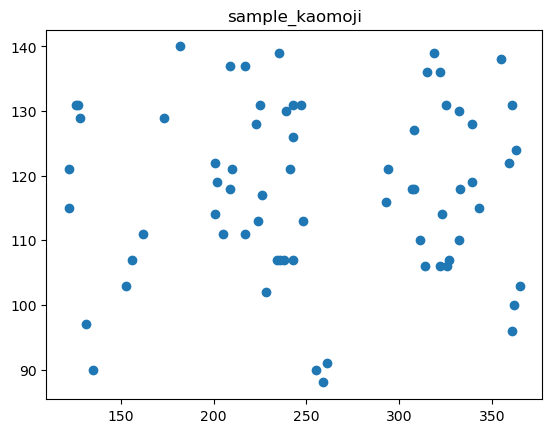

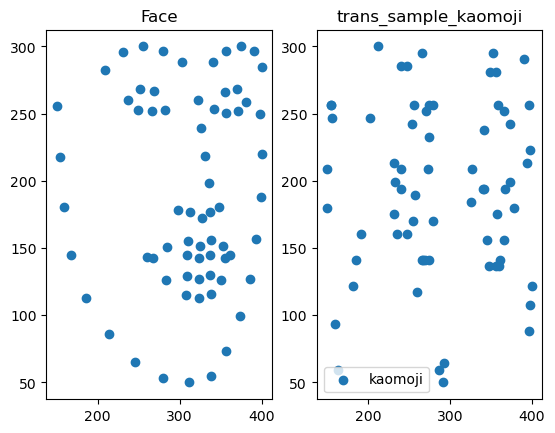

In [171]:
def process_folder(folder_path, shapes1, weights, max_values):
    #get scores of all picture
    scores = {}
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        shapes2 = extract_all_non_white_points(image_path)
        #print(shapes2)
        x_range = (150, 400)
        y_range = (50, 300)
        shapes1_new = transform_points(shapes1[0], x_range, y_range)
        shapes2_new = transform_points(shapes2, x_range, y_range)
        score = perform_comparisons(shapes1_new, shapes2_new, weights, max_values)
        scores[image_file] = score
        #print(f"Score for {image_file}: {score:.2f}") 
    return scores


folder_path = 'images'  
scores = process_folder(folder_path, shapes1, weights, max_values)
highest_score_image , max_score = max(scores.items(), key=lambda x: x[1])
print(f"The image with the highest score: {highest_score_image} {max_score}")
highest_score_image_path = os.path.join(folder_path, highest_score_image)

x_range = (150, 400)
y_range = (50, 300)
shapes2 = extract_all_non_white_points(highest_score_image_path,test=True)
print(shapes2)
shapes1_new = transform_points(shapes1[0], x_range, y_range)
shapes2_new = transform_points(shapes2, x_range, y_range)
plt.scatter(*zip(*shapes2), label='sample_kaomoji')
plt.title('sample_kaomoji')
plt.show()
plt.subplot(1, 2, 1)
plt.scatter(*zip(*shapes1_new), label='Face')
plt.title('Face')
plt.subplot(1, 2, 2)
plt.scatter(*zip(*shapes2_new), label='kaomoji')
plt.title('trans_sample_kaomoji')
plt.legend()
plt.show()


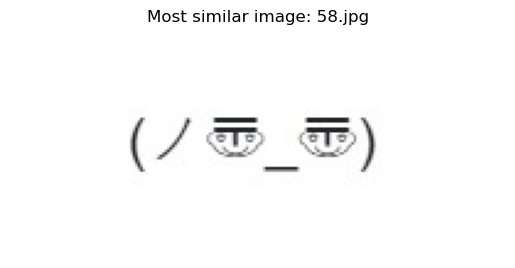

In [172]:
img = Image.open(highest_score_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Most similar image: {highest_score_image}")
plt.show()